### Preprocessing

In this notebook, we analyzed some pre-processing tecniques. Preprocessing is a crucial step in Natural Language Processing (NLP) that involves transforming raw text into a format suitable for analysis. This process is essential for several reasons:
* Noise Reduction: Raw text data often contains noise such as punctuation, special characters, and irrelevant information which can adversely affect the performance of NLP models.

* Normalization: Text normalization steps like lowercasing and stemming help in reducing variations in the text, making the data more uniform and easier to process.

* Efficiency: Preprocessing can significantly reduce the dimensionality of the data, which leads to faster processing times and reduced computational costs.

* Improved Model Performance: Cleaned and well-prepared data generally leads to more accurate and reliable NLP models. This is because the models can focus on the relevant patterns and structures within the text.

#### Preprocessing Techniques for YELP Review Dataset
* Tokenization
    * Advantages: Simplifies text processing by breaking down text into manageable pieces.
    * Disadvantages: Basic tokenization might not handle compound words or idioms effectively, potentially losing context.
<br /><br />
* Lowercasing
    * Advantages: Reduces the complexity by making the text case-insensitive, ensuring uniformity.
    * Disadvantages: Loss of information where case sensitivity matters, such as proper nouns.
<br /><br /> 
* Stopword Removal
    * Advantages: Reduces dimensionality and noise, focusing on more informative words.
    * Disadvantages: Risk of losing context or meaning if important stopwords are removed.
<br /><br />
* Stemming and Lemmatization
    * Advantages: Reduces variations of words, simplifying analysis.
    * Disadvantages: Stemming can be too aggressive and remove necessary parts of words, while lemmatization is computationally more intensive and requires more resources.
<br /><br />
* Removing Punctuation and Special Characters
    * Advantages: Reduces noise and potential non-informative elements in the text.
    * Disadvantages: Might lead to loss of sentiment indicators (e.g., exclamation marks) that can be important for sentiment analysis.
<br /><br />
* Text Cleaning (URL, Email etc)
    * Advantages: Ensures that only relevant textual information is retained.
    * Disadvantages: Requires robust regular expressions or libraries to effectively clean the data without removing useful information.
<br /><br />
* Spell Check
    * Advantages: Corrects wrong spelled words in order to increase of sentence
    * It is a very complicated task. Also it may lead correcting true words into wrong words.
<br /><br />
* Slang Correction
    * Advantages: For human input such as review, it can help to make sentence more meaningful (SMS phrases, internet jargon)
    * Disadvantages: It is a very complicated task. Keeping this process current is also hard because internet jargon is changing often.

In our project we will explain some tokenization techniques such as using BERT Tokenizer later. So in the prepocessing step we tokenize text by blank spaces. We focused on other techniques and tools that we can use.

In [ ]:
# Needed libraries
import re
import json
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

from datasets import load_dataset
dataset = load_dataset("yelp_review_full")

import pandas as pd
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])
x = train_df['text']
y = train_df['label']


Firstly we will see the techniques and the codes of the steps. Then later on notebook some models are used to test the effectiveness of the techniques.

##### Lowercase

If we apply ```lower()``` to all sentences, does it affect negatively the meaning of the review? Answer is ```NO```, so we made all review lover case. Also, for later, this enables us to use ```bert-uncased```.

All the models (from logistic regression to neural networks) we applied lowercasing.

##### Stopwords

We have removed some of the stopwords indicating sentiment of the sentence. 

In [ ]:
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')
all_stopwords.remove('no')
all_stopwords.remove('but')
all_stopwords.remove("won't")
all_stopwords = set(all_stopwords)

In [ ]:

dataset_without_stopwords = []
for i, text in enumerate(x):
  words = text.split()
  words = [word for word in words if word not in all_stopwords]
  dataset_without_stopwords.append(' '.join(words))

Removing stopwords did not affect the models in a good way. (See next chapter on the notebook)

##### Special Characters and Punctuation

Removing special characters can reduce the impact of some emotions of course. However, for these sentences, it is very likely to have other words related to these emotions. For example:
* Awesomee! I liked it :\)
* Very bad taste of food. feeling angry to service :@

In [ ]:
!pip install contractions

In [ ]:
import contractions
dataset_without_special_characters_and_punctuation = []
for i, tex in enumerate(x):
    # Convert text to UTF-8 encoding
    text_new = text.encode('utf-8').decode('utf-8')

    # Convert special characters
    text_new = text_new.lower().replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').replace('\\n', ' ').replace('\\r', ' ').replace('\\t', ' ')

    # Expand contractions
    text_new = contractions.fix(text_new)

    # Remove quotation marks around words
    text_new = re.sub(r'\"(\w+)\s*\"', r'\1', text_new)

    # Replace dots that are not between numbers with a space
    text_new = re.sub(r'(?<!\d)\.|\.(?!\d)', ' ', text_new)

    # Handle punctuation (excluding numbers)
    text_new = re.sub(r"[^\w\s\.]", r" ", text_new)

    # Handle dots at the end of sentences (excluding numbers)
    text_new = re.sub(r"\b\.(?!\d)", r" ", text_new)
    dataset_without_special_characters_and_punctuation.append(text_new)

##### Cleaning URLs and Emails
Does text contains any markup, or some words that have non-content information?
There is a bunch of methods to find out if a string is url or not, but spacy library is most trusted compared to other tools like regex etc. It is most slow one though.

Also checking if word is email or not.

Drawback: Too long and not no prominent improvement of the model.

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

dataset_without_url_and_email = []

for doc in nlp.pipe(x, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):
  words = []
  for token in doc:
      if token.like_url:
          continue
      if token.like_email:
          continue
      else:
        words.append(token.text)
  dataset_without_url_and_email.append(' '.join(words))



##### Spell Check

Considering the dataset, it is a valid point that users often make their review in very informal way. They can make misspelling, use slang words etc.
* Misspelling can change the meaning of sentence as expexted.
* Slangs can generally have a real meaning other than the meaning that comes to mind at first glance.

At this point, tokenization this kind of review can lead to missing some information [1].
Also we noticed that most of the spelling libraries are not very succesfull for recognizing some nouns, especially they are related to a specific domain.

We investigated TextBlob results. However it changes some word in very undesirable way. For example:
* appetizer -> appetize
* garbage -> garage
* thrift -> thrifty

Its harm to meaning of sentence dominated its potential advantages.

In [ ]:
!pip install textblob

In [ ]:
from textblob import TextBlob
dataset_text_blob = []
for i, text in enumerate(x):
  corrected = str(TextBlob(text).correct())
  dataset_text_blob.append(corrected)

Considering the [4], Gingerit is the best API that can give better results compating other tools we have. However, it is not free and API limits are very low.

We also use the 'autocorrect' library to correct the wrongly spelled words.

In [ ]:
!pip install autocorrect

In [ ]:
import itertools
from autocorrect import Speller

#One letter in a word should not be present more than twice in continuation
dataset_spell_checked = []
i = 0
spell = Speller(lang='en', fast=True)
for i, text in enumerate(x):
  ans = spell(text)
  dataset_spell_checked.append(ans)

As we see in TextBlob, this library also changes some correct words and makes model worse. Testing of these techniques are available in logictis regression part of notebook.

##### Slang Removal

We scrape the website https://www.noslang.com/ and created a dictionary. This dictionary contains the true version of the slangs using in the internet.
* nyc: New York City
* asap: as soon as possible
* afaik: as far as i know

For example some slangs can be:

* WD: Well done!
* Headdesk: Frustration

At this point we will employ slang dictionary to replace the slang words with their real meaning.

In [ ]:
slang_dict = json.load(open('slang.json', 'r'))

dataset_without_slang = []
for i, text in enumerate(x):
  words = text.split()
  corrected_slang_words = []
  for word in words:
    if word in slang_dict:
      word = slang_dict[word]
    corrected_slang_words.append(word)

  dataset_without_slang.append(' '.join(corrected_slang_words))

Slang removal helps to model to improve because people often tends to use this kind of words in reviews.

##### Stemming and Lemmatization

Stemming is also very beneficial because it makes use of root of the words and helps to represenet the meaning of the sentence. However it can cause *False-Positive* results sometimes [2].

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
lemmatized_dataset = []
for text in x:
  words = nltk.word_tokenize(text)
  words = [lemmatizer.lemmatize(word) for word in words]
  lemmatized_dataset.append(' '.join(words))


We saw that using stemming and lemmatization affected the sentiment of the sentence because positive/negative words turned into their roots with less meaning (less informative).

##### Final Preprocessing

In [ ]:
def preprocess(row):
    # Convert text to UTF-8 encoding
    text = row['text'].encode('utf-8').decode('utf-8')

    # Convert special characters
    text = text.lower().replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').replace('\\n', ' ').replace('\\r', ' ').replace('\\t', ' ')

    # Expand contractions
    text = contractions.fix(text)

    # Remove quotation marks around words
    text = re.sub(r'\"(\w+)\s*\"', r'\1', text)

    # Replace dots that are not between numbers with a space
    text = re.sub(r'(?<!\d)\.|\.(?!\d)', ' ', text)

    # Handle punctuation (excluding numbers)
    text = re.sub(r"[^\w\s\.]", r" ", text)

    # Handle dots at the end of sentences (excluding numbers)
    text = re.sub(r"\b\.(?!\d)", r" ", text)
    ## Replacing slangs
    words = text.split()
    corrected_slang_words = []
    for word in words:
        if word in slang_dict:
            word = slang_dict[word].lower()
        corrected_slang_words.append(word)

    row["text"] = ' '.join(corrected_slang_words)
    return row

#### REFERENCES
[1] Gharatkar, S., Ingle, A., Naik, T.R., & Save, A.M. (2017). Review preprocessing using data cleaning and stemming technique. 2017 International Conference on Innovations in Information, Embedded and Communication Systems (ICIIECS), 1-4.

[2] Ms. Anjali Ganesh Jivani, “A Comparative Study of Stemming
Algorithms”, IJCTA, Volume 2, 2011, pp 1930-1938.

[3] Wang, M., & Qiu, R. (2015). Text Mining for Yelp Dataset Challenge.

[4] Cahyaningtyas, S., Fudholi, D.H., & Hidayatullah, A.F. (2021). Deep Learning for Aspect-Based Sentiment Analysis on Indonesian Hotels Reviews. Kinetik: Game Technology, Information System, Computer Network, Computing, Electronics, and Control.

[5] Ekawati, D., & Khodra, M.L. (2017). Aspect-based sentiment analysis for Indonesian restaurant reviews. 2017 International Conference on Advanced Informatics, Concepts, Theory, and Applications (ICAICTA), 1-6.

[6] https://github.com/Azd325/gingerit

[7] https://medium.com/coinmonks/remaking-of-shortened-sms-tweet-post-slangs-and-word-contraction-into-sentences-nlp-7bd1bbc6fcff

[8] https://textblob.readthedocs.io/en/dev/

### Preprocessing Experiments, Linear Regression, Logistic Regression and SVM 

Before moving on to neural network-based solutions, we focused on linear solutions that we could develop on the dataset. In this direction, we have developed different models that give precision between 50-58% using Linear Regression, Logistic Regression and SVM. Let's start by explaining the effects of preprocessing steps on loss.

Firstly, we created a corpus by applying following preprocessing steps using the codes above:
* Lowercase
* Stopword Removal
* Special Characters and Punctuation
* Url and Email removal
* Spell Checking with Autocorrect library
* Lemmatization
* Slang Removal
You can find the full scripts and notebook on the Github.

In [ ]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model
from sklearn import metrics
import math

Note that this is not the result of above finalized ```preprocess``` function. Indeed, it is finalized after the below experiments.

In [ ]:
# If you want to run cell please put the correct file location. 
# Corpus is available in Github repository

train_data = []
with open('/kaggle/input/preprocessed-real/corpus_preprocessed.json', 'r') as f:
    train_data = json.load(f)

test_data = []
with open('/kaggle/input/preprocessed-real/test_corpus_preprocessed.json', 'r') as f:
    test_data = json.load(f)

#make df
import pandas as pd
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

As a first step, naturally, we tried count vectorizer on the full preprocessed corpus.

In [ ]:
vectorizer = CountVectorizer(ngram_range = (1, 2), min_df=10)
def fit_linear_model(x,y):
    x_train, x_val, y_train, y_val = model_selection.train_test_split(x, y, test_size = 0.2, random_state = 2022)

    # initialize the vectorizer class instance with some configurations

    # fitting (learn) the vectorizer with the vocab in the training set
    vectorizer.fit(x_train)
    # then transform the original training data and test data into document-term matrices
    # with the fitted vectorizer
    X_train = vectorizer.transform(x_train)
    X_test = vectorizer.transform(x_val)

    X_train.toarray()
    X_test.toarray()
    Y_train = np.array(y_train)
    Y_test = np.array(y_val)

    regr = linear_model.LinearRegression()
    regr.fit(X_train, Y_train)
    return regr, X_test, Y_test

In [ ]:
x = train_df[:65000]['text']
y = train_df[:65000]['label']
regr, X_test, Y_test = fit_linear_model(x,y)

LinearRegression()

In [ ]:
Y_pred = regr.predict(X_test)
ssr = np.sum(Y_pred - np.mean(Y_test)) ** 2
mse = metrics.mean_squared_error(Y_test, Y_pred)
rmse = math.sqrt(mse)
print('R^2 score: %.2f' % regr.score(X_test, Y_test))
print('RMSE: %.2f' % rmse)

R^2 score: -86.97
RMSE: 13.41


Results are terrible. We understand that there must be a problem related to the preprocessing.

In [ ]:
#Create a dataframe containing attributes with actual words via .get_feature_names() method,
#with their corresponding coefficient values
df_features = pd.DataFrame(data = {'Coefficient':list(regr.coef_),'Feature_Name':vectorizer.get_feature_names_out()})
#create coefficient magnitude column and sort the dataframe by this column
#followed by getting the top 10 coefficients
df_features['Coefficient_Magnitude'] = abs(df_features['Coefficient'])
df_features.sort_values(by='Coefficient_Magnitude', ascending=False).head(10)

,Coefficient,Feature_Name,Coefficient_Magnitude
45193,26.764586,tammie coe,26.764586
10717,-23.622950,dac,23.622950
20933,-22.304135,heirloom tomato,22.304135
20932,20.752112,heirloom,20.752112
45192,-20.358046,tammie,20.358046
33492,19.593876,payment and,19.593876
33973,18.920227,pho dac,18.920227
3995,-18.658192,barnes noble,18.658192
10823,18.348454,daughter wanted,18.348454
49461,-18.082241,waiter gave,18.082241


The features are too meaningless even though coefficient magnitudes are too big. This means that these unmeaningful words affect too much the model. Let's try with dataset itself without preprocessing.

In [ ]:
from datasets import load_dataset
dataset = load_dataset("yelp_review_full")

import pandas as pd
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

In [ ]:
x = train_df[:65000]['text']
y = train_df[:65000]['label']

In [ ]:
regr, X_test, Y_test = fit_linear_model(x,y)

LinearRegression()

In [ ]:
Y_pred = regr.predict(X_test)
ssr = np.sum(Y_pred - np.mean(Y_test)) ** 2
mse = metrics.mean_squared_error(Y_test, Y_pred)
rmse = math.sqrt(mse)
print('R^2 score: %.2f' % regr.score(X_test, Y_test))
print('RMSE: %.2f' % rmse)

R^2 score: -4.76
RMSE: 3.43


In [ ]:
#Create a dataframe containing attributes with actual words via .get_feature_names() method,
#with their corresponding coefficient values
df_features = pd.DataFrame(data = {'Coefficient':list(regr.coef_),'Feature_Name':vectorizer.get_feature_names_out()})
#create coefficient magnitude column and sort the dataframe by this column
#followed by getting the top 10 coefficients
df_features['Coefficient_Magnitude'] = abs(df_features['Coefficient'])
df_features.sort_values(by='Coefficient_Magnitude', ascending=False).head(10)

,Coefficient,Feature_Name,Coefficient_Magnitude
59793,4.942655,service terrible,4.942655
37576,3.433772,life has,3.433772
64832,3.049920,surprised the,3.049920
59715,3.024919,service horrible,3.024919
64395,-2.873843,subs and,2.873843
22650,-2.767547,fabulous but,2.767547
41997,2.722037,motorcycles,2.722037
71579,2.712590,this wal,2.712590
72263,2.702900,timing,2.702900
57303,-2.476710,rock music,2.476710


It is really obvious that some step in preprocessing disrupts sentence semantics in a way that prevents us from doing linear regression over sentences. Let's go step by step to find this step.

In [ ]:
x = train_df[:65000]['text']
y = train_df[:65000]['label']

In [ ]:
x[1]

"Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars."

**Problems like sentiment analysis are much more sensitive to stop words removal than document classification.**

Lowercasing is a trivial process so we apply it first.

In [ ]:
new_x = []
for i, text in enumerate(x):
    new_text = text.lower().replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').replace('\\n', ' ').replace('\\r', ' ').replace('\\t', ' ')
    new_x.append(new_text)
x = new_x

In [ ]:
x[1]

"unfortunately, the frustration of being dr. goldberg's patient is a repeat of the experience i've had with so many other doctors in nyc -- good doctor, terrible staff.  it seems that his staff simply never answers the phone.  it usually takes 2 hours of repeated calling to get an answer.  who has time for that or wants to deal with it?  i have run into this problem with many other doctors and i just don't get it.  you have office workers, you have patients with medical needs, why isn't anyone answering the phone?  it's incomprehensible and not work the aggravation.  it's with regret that i feel that i have to give dr. goldberg 2 stars."

In [ ]:
slang_dict = json.load(open('/kaggle/input/english-slang/slang.json', 'r'))

new_x = []
for text in x:
  words = text.split()
  corrected_slang_words = []
  for word in words:
    if word in slang_dict:
      word = slang_dict[word].lower()
    corrected_slang_words.append(word)

  new_x.append(' '.join(corrected_slang_words))

x = new_x

In [ ]:
x[1]

"unfortunately, the frustration of being dr. goldberg's patient is a repeat of the experience i've had with so many other doctors in new york city -- good doctor, terrible staff. it seems that his staff simply never answers the phone. it usually takes 2 hours of repeated calling to get an answer. who has time for that or wants to deal with it? i have run into this problem with many other doctors and i just don't get it. you have office workers, you have patients with medical needs, why isn't anyone answering the phone? it's incomprehensible and not work the aggravation. it's with regret that i feel that i have to give dr. goldberg 2 stars."

In [ ]:
regr, X_test, Y_test = fit_linear_model(x,y)

LinearRegression()

In [ ]:
Y_pred = regr.predict(X_test)
ssr = np.sum(Y_pred - np.mean(Y_test)) ** 2
mse = metrics.mean_squared_error(Y_test, Y_pred)
rmse = math.sqrt(mse)
print('R^2 score: %.2f' % regr.score(X_test, Y_test))
print('RMSE: %.2f' % rmse)

R^2 score: -4.69
RMSE: 3.41


RMSE is a bit lower. So changing the slang word with their real meaning of the slang is a helpful technique as we expected.

In [ ]:
x = train_df[:65000]['text']
y = train_df[:65000]['label']

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

x_without_url = []

for doc in nlp.pipe(x, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):
  words = []
  for token in doc:
      if token.like_url:
          continue
      if token.like_email:
          continue
      else:
        words.append(token.text)
  x_without_url.append(' '.join(words))

x = x_without_url

In [ ]:
regr, X_test, Y_test = fit_linear_model(x,y)

In [ ]:
Y_pred = regr.predict(X_test)
ssr = np.sum(Y_pred - np.mean(Y_test)) ** 2
mse = metrics.mean_squared_error(Y_test, Y_pred)
rmse = math.sqrt(mse)
print('R^2 score: %.2f' % regr.score(X_test, Y_test))
print('RMSE: %.2f' % rmse)

R^2 score: -4.76
RMSE: 3.43


OK. Not a disaster like the first model. We started suspect that problem is lemmatization. But this step is too long and not effective so we will also discard it.

In [ ]:
x = train_df[:65000]['text']
y = train_df[:65000]['label']

Let's try a spell checking library to correct some misspelled words. You can find the experiments with these libraries later on notebook. Most of these libraries corrupts some specific nouns, such as:
* pesto -> pest
* calzone -> canzone

In [ ]:
import itertools
from autocorrect import Speller

#One letter in a word should not be present more than twice in continuation
x_spell_checked = []

spell = Speller(lang='en', fast=True)
for text in x:
  ans = spell(text)
  x_spell_checked.append(ans.lower())

x = x_spell_checked

In [ ]:
x[10]

"owning a driving range inside the city limits is like a license to print money . i do n't think i ask much out of a driving range . decent mats , clean balls and accessible hours . hell you need even less people now with the advent of the machine that does out the balls . this place has none of them . it is april and there are no grass tees yet . by the way they opened for the season this week although it has been golfing weather for a month . the mats look like the carpet at my 107 year old aunt irene 's house . worn and thread bare . let 's talk about the hours . this place is equipped with lights yet they only sell buckets of balls until 730 . it is still light out . finally lets you have the pit to hit into . when i arrived i was n't sure if this was a driving range or an excavation site for a mastodon or a strip mining operation . there is no grass on the range . just mud . makes it a good tool to figure out how far you actually are hitting the ball . oh , they are cash only also

In [ ]:
regr, X_test, Y_test = fit_linear_model(x,y)

LinearRegression()

In [ ]:
Y_pred = regr.predict(X_test)
ssr = np.sum(Y_pred - np.mean(Y_test)) ** 2
mse = metrics.mean_squared_error(Y_test, Y_pred)
rmse = math.sqrt(mse)
print('R^2 score: %.2f' % regr.score(X_test, Y_test))
print('RMSE: %.2f' % rmse)

R^2 score: -4.73
RMSE: 3.42


Features derived from this model:

In [ ]:
#Create a dataframe containing attributes with actual words via .get_feature_names() method,
#with their corresponding coefficient values
df_features = pd.DataFrame(data = {'Coefficient':list(regr.coef_),'Feature_Name':vectorizer.get_feature_names_out()})
#create coefficient magnitude column and sort the dataframe by this column
#followed by getting the top 10 coefficients
df_features['Coefficient_Magnitude'] = abs(df_features['Coefficient'])
df_features.sort_values(by='Coefficient_Magnitude', ascending=False).head(10)

,Coefficient,Feature_Name,Coefficient_Magnitude
58928,4.437789,service terrible,4.437789
37777,3.302069,life has,3.302069
42263,3.212980,motorcycles,3.212980
63545,-3.016461,subs and,3.016461
63991,2.962433,surprised the,2.962433
41392,-2.809754,mile and,2.809754
58856,2.771312,service horrible,2.771312
22786,-2.650515,fabulous but,2.650515
70753,2.625733,this wal,2.625733
22246,-2.524600,excellent place,2.524600


So we are sure that the problem is lemmatization. It really harms the score. But still our model is not very well so we have to improve the linear regression model here.

In [ ]:
from nltk.stem import *
stemmer = SnowballStemmer(ignore_stopwords=True, language="english")

We don't want word like "won't,, become" to be stemmed. So we ignore the stopword while stemming.

In [ ]:
x = train_df[:65000]['text']
y = train_df[:65000]['label']

In [ ]:
x_snowball_stemmer = []
for text in x:
    text_new = ''
    for word in text.split():
        word_stemmed = stemmer.stem(word)
        text_new = text_new + word_stemmed + ' '
    x_snowball_stemmer.append(text_new)

In [ ]:
x_snowball_stemmer[10]

"own a drive rang insid the citi limit is like a licens to print money . i do n't think i ask much out of a drive rang . decent mat , clean ball and access hour . hell you need even less peopl now with the advent of the machin that does out the ball . this place has none of them . it is april and there are no grass tee yet . by the way they open for the season this week although it has been golf weather for a month . the mat look like the carpet at my 107 year old aunt iren 's hous . worn and thread bare . let 's talk about the hour . this place is equip with light yet they only sell bucket of ball until 730 . it is still light out . final let you have the pit to hit into . when i arriv i was n't sure if this was a drive rang or an excav site for a mastodon or a strip mine oper . there is no grass on the rang . just mud . make it a good tool to figur out how far you actual are hit the ball . oh , they are cash only also . bottom line , this place suck . the best hope is that the owner 

In [ ]:
regr, X_test, Y_test = fit_linear_model(x_snowball_stemmer,y)

In [ ]:
Y_pred = regr.predict(X_test)
ssr = np.sum(Y_pred - np.mean(Y_test)) ** 2
mse = metrics.mean_squared_error(Y_test, Y_pred)
rmse = math.sqrt(mse)
print('R^2 score: %.2f' % regr.score(X_test, Y_test))
print('RMSE: %.2f' % rmse)

R^2 score: -5.34
RMSE: 3.60


It is way worse. Even ignoring stopwords, stemming works poorly. 

In sentiment analysis, lemmatization or stemming can reduce the meaning of the sentence and lead to worse results, sometimes. It depends on the dataset characteristics. In our dataset we couldn't manage to get better results with both of them

**IN FOLLOWING STEPS, FINALIZED ```preprocess``` FUNCTION IS USED.**

In [ ]:
x = train_df[:65000]['text']
y = train_df[:65000]['label']
final_x = []
for i, text in enumerate(x):
    row = {'text': text, 'label': y[i]}
    preprocessed_row = preprocess(row)
    final_x.append(preprocessed_row['text'])

x = final_x

#### Regularized Linear Regression

Regularized linear regression introduces a penalty term to the cost function to prevent overfitting. This penalty discourages the model from fitting too closely to the training data, thereby enhancing its generalization capability to unseen data

In [ ]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(x, y, test_size = 0.2, random_state = 2022)

# initialize the vectorizer class instance with some configurations
vectorizer = CountVectorizer(ngram_range = (1, 2), min_df=10)

# fitting (learn) the vectorizer with the vocab in the training set
vectorizer.fit(x_train)
# then transform the original training data and test data into document-term matrices
# with the fitted vectorizer
X_train = vectorizer.transform(x_train)
X_test = vectorizer.transform(x_val)

X_train.toarray()
X_test.toarray()
Y_train = np.array(y_train)
Y_test = np.array(y_val)

In [ ]:
X_train.shape

(52000, 83026)

In scikit-learn, Lasso is a linear model that implements Lasso regression, which is a type of linear regression that includes L1 regularization. This regularization technique adds a penalty equal to the absolute value of the magnitude of the coefficients, encouraging sparsity in the model.

In [ ]:
alpha_list = [0.0001, 0.001, 0.01]
col_labels_lasso = ['Alpha', 'Training RMSE', 'Model Complexity - Coef Norm1', 'Model Complexity - Coef Sum', 'Test RMSE']

result_lasso_arr = []
for alpha in alpha_list:
    result_lasso_list=[]
    #build model:
    lasso = linear_model.Lasso(alpha,max_iter=10)
    print(f'Training for {alpha}')
    lasso.fit(X_train, Y_train)
    print("Training finalized")
    #applied to test data
    Y_pred_test = lasso.predict(X_test)
    mse_test = metrics.mean_squared_error(Y_test, Y_pred_test)
    rmse_test = math.sqrt(mse_test)
    #applied to train data
    Y_pred_train = lasso.predict(X_train)
    mse_train = metrics.mean_squared_error(Y_train, Y_pred_train)
    rmse_train = math.sqrt(mse_train)
    #compute complexity by L1-norm of the model parameter values
    complexity_coef_norm1 = np.linalg.norm(lasso.coef_, ord=1)
    #compute complexity by sum of the model parameter magnitudes
    complexity_coef_sum = np.sum(np.abs(lasso.coef_))
    #output result
    print(f'Alpha value: {alpha}')
    print(f'Train RMSE: {rmse_train}')
    print(f'Model Complexity - Norm1 of Coefficients: {complexity_coef_norm1}')
    print(f'Model Complexity - Sum of Coefficients: {complexity_coef_sum}')
    print(f'Test RMSE: {rmse_test}\n')
    result_lasso_list = [alpha, rmse_train, complexity_coef_norm1, complexity_coef_sum, rmse_test]
    result_lasso_arr.append(result_lasso_list)
    
df_lasso = pd.DataFrame(result_lasso_arr,columns=col_labels_lasso)

Training for 0.0001


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18607.75878975823, tolerance: 10.460821075000041
  model = cd_fast.sparse_enet_coordinate_descent(


Training finalized
Alpha value: 0.0001
Train RMSE: 0.7156784256539539
Model Complexity - Norm1 of Coefficients: 1039.8791239616899
Model Complexity - Sum of Coefficients: 1039.8791239616899
Test RMSE: 1.0063802357256755

Training for 0.001


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26164.75824877238, tolerance: 10.460821075000041
  model = cd_fast.sparse_enet_coordinate_descent(


Training finalized
Alpha value: 0.001
Train RMSE: 0.956884346349361
Model Complexity - Norm1 of Coefficients: 60.433988730656154
Model Complexity - Sum of Coefficients: 60.433988730656154
Test RMSE: 0.9855948663900004

Training for 0.01
Training finalized
Alpha value: 0.01
Train RMSE: 1.0888677306849095
Model Complexity - Norm1 of Coefficients: 9.70703962061009
Model Complexity - Sum of Coefficients: 9.70703962061009
Test RMSE: 1.1021936350665638



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27984.764867169706, tolerance: 10.460821075000041
  model = cd_fast.sparse_enet_coordinate_descent(


In [ ]:
df_lasso

,Alpha,Training RMSE,Model Complexity - Coef Norm1,Model Complexity - Coef Sum,Test RMSE
0,0.0001,0.715678,1039.879124,1039.879124,1.006380
1,0.0010,0.956884,60.433989,60.433989,0.985595
2,0.0100,1.088868,9.707040,9.707040,1.102194


It can be seen that model gives lowest error when alpha regularization parameter equals  0.001. Let's regenerate the best performing model.

In [ ]:
# Regenerate the best performing model:
lasso_best = linear_model.Lasso(0.001, max_iter=10)
lasso_best.fit(X_train, Y_train)
df_lasso_features = pd.DataFrame(data = {'Coefficient':list(lasso_best.coef_),'Feature_Name':vectorizer.get_feature_names_out()})
df_lasso_features['Coefficient_Magnitude'] = abs(df_lasso_features['Coefficient'])
df_lasso_features.sort_values(by='Coefficient_Magnitude', ascending=False).head(10)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26164.75824877238, tolerance: 10.460821075000041
  model = cd_fast.sparse_enet_coordinate_descent(


,Coefficient,Feature_Name,Coefficient_Magnitude
81693,-0.460217,worst,0.460217
7286,-0.450103,at best,0.450103
43980,-0.447531,never again,0.447531
39463,0.400815,love this,0.400815
45295,-0.389304,not recommend,0.389304
32076,-0.373423,horrible,0.373423
8850,0.351327,be disappointed,0.351327
65226,-0.333797,terrible,0.333797
2864,0.330529,amazing,0.330529
37036,0.326365,knowledgeable,0.326365


Sentiment of the words are not that correct however magnitudes and best features are quite understandable.

**But Linear Regression is not suitable for classification. Linear Regression deals with continuous values whereas classification problems mandate discrete values.**

#### Logistic Regression

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.5704615384615385
Confusion Matrix:
 [[2206  579  136   32   52]
 [ 590 1274  546  130   57]
 [ 135  408 1255  538  153]
 [  36   73  562 1120  726]
 [  53   28  159  591 1561]]


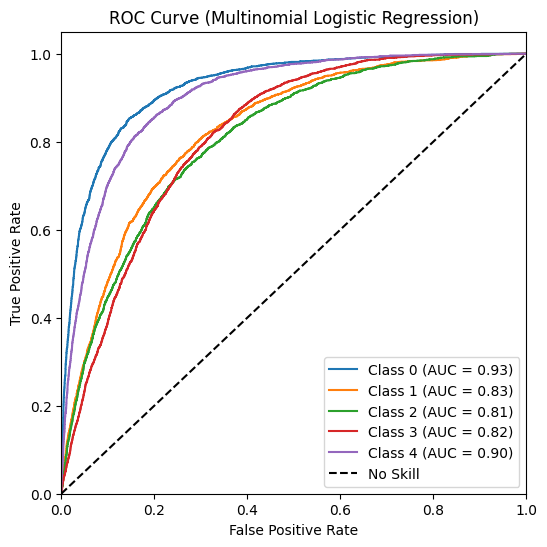

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc


# Create a multinomial logistic regression classifier
classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Train the classifier
classifier.fit(X_train, y_train)

# Predict class labels for test data
y_pred_test = classifier.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(Y_test, y_pred_test)
print("Accuracy:", accuracy)

# Calculate Confusion Matrix
confusion_matrix_result = confusion_matrix(Y_test, y_pred_test)
print("Confusion Matrix:\n", confusion_matrix_result)

# ROC Curve and AUC Score
# One-vs-Rest approach for ROC curve (as Multinomial Logistic Regression doesn't directly output probabilities)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(classifier.classes_)

for i in range(n_classes):
    y_test_binary = (Y_test == i)  # Binarize for each class
    fpr[i], tpr[i], _ = roc_curve(y_test_binary, classifier.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class %d (AUC = %0.2f)' % (i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multinomial Logistic Regression)')
plt.legend(loc="lower right")
plt.show()

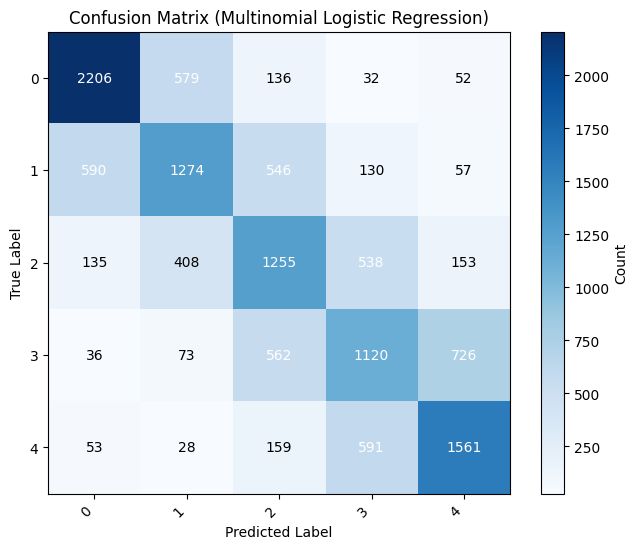

In [ ]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix_result, cmap='Blues')
plt.colorbar(label='Count')

# Set labels for axes
class_names = [str(x) for x in range(len(classifier.classes_))]  # Adapt based on your class names
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.yticks(range(len(class_names)), class_names)

# Add text for each cell (optional)
for i in range(len(confusion_matrix_result)):
    for j in range(len(confusion_matrix_result[0])):
        plt.text(j, i, confusion_matrix_result[i, j], ha='center', va='center', color='white' if confusion_matrix_result[i, j] > np.mean(confusion_matrix_result) else 'black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Multinomial Logistic Regression)')
plt.show()

Results are really good. So we will investigate Logistic Regression further later by changing embedding. But is there anything we can do more with tokenized data after all these steps?  

In this step we read about POS Tagging in sentiment analysis. We decided to make an analysis that whether POS Tagging can be helpful for our model or not.

In [ ]:
data = {"text":x,"labels":y}
df = pd.DataFrame(data)

In [ ]:
df.head()

,text,labels
0,dr goldberg offers everything i look for in a ...,4
1,unfortunately the frustration of being dr gold...,1
2,been going to dr goldberg for over 10 years i ...,3
3,got a letter in the mail last week that said d...,3
4,i do not know what dr goldberg was like before...,0


In [ ]:
import nltk
# Conduct POS Tagging (takes a bit of time to run this code)
pos_tags = (df.text.apply(lambda text: nltk.pos_tag(nltk.word_tokenize(text))))

In [ ]:
def pos_tag_count(list_of_postag):
    # Return dictionary of dataframes with postags as keys and counts as values
    dict_of_postags = {}
    for tag in list_of_postag:
        dict_of_postags[tag[1]] = dict_of_postags.get(tag[1], 0) + 1
    return dict_of_postags
        
postags_df = pd.DataFrame(pos_tags.apply(pos_tag_count).to_dict()).T

In [ ]:
pos_tag_col = [col for col in postags_df.columns if re.findall('[A-Z]+', col)]

postags_df_ = postags_df[pos_tag_col].fillna(0)

In [ ]:
postags_df_.head

<bound method NDFrame.head of          NN  VBZ  VBP    IN    DT    JJ   PRP    CC   TO    VB  ...  JJS   EX  \
0      12.0  5.0  8.0  10.0   4.0   7.0   9.0   4.0  6.0   6.0  ...  0.0  0.0   
1      24.0  9.0  7.0  14.0   9.0  11.0   8.0   3.0  3.0   6.0  ...  0.0  0.0   
2      12.0  7.0  2.0  14.0   7.0   9.0   7.0   6.0  2.0   4.0  ...  0.0  0.0   
3      11.0  1.0  1.0   6.0   5.0   7.0   2.0   0.0  3.0   5.0  ...  0.0  0.0   
4      36.0  7.0  8.0  19.0  24.0  13.0  17.0  10.0  7.0  19.0  ...  0.0  0.0   
...     ...  ...  ...   ...   ...   ...   ...   ...  ...   ...  ...  ...  ...   
29995   5.0  1.0  2.0   2.0   4.0   2.0   1.0   3.0  1.0   1.0  ...  0.0  0.0   
29996  42.0  4.0  6.0  18.0  24.0  13.0   3.0   7.0  1.0   5.0  ...  3.0  2.0   
29997  24.0  4.0  6.0  18.0  12.0  11.0   4.0   5.0  2.0   5.0  ...  0.0  1.0   
29998  14.0  3.0  1.0   5.0  10.0  14.0   4.0   6.0  2.0   5.0  ...  0.0  0.0   
29999  22.0  2.0  6.0  12.0   9.0   8.0   9.0   4.0  4.0   6.0  ...  0.0  0.0  

In [ ]:
pt_df = postags_df_
import seaborn as sns
pt_df['0'] = pd.get_dummies(df.labels)[0]
pt_df['1'] = pd.get_dummies(df.labels)[1]
pt_df['2'] = pd.get_dummies(df.labels)[2]
pt_df['3'] = pd.get_dummies(df.labels)[3]
pt_df['4'] = pd.get_dummies(df.labels)[4]

In [ ]:
pt_df.corr()[['0','1','2','3','4']]

,0,1,2,3,4
NN,0.061131,0.058885,0.003624,-0.038499,-0.089251
VBZ,-0.044270,0.012891,0.042756,0.021452,-0.034754
VBP,-0.005431,0.019128,0.002538,0.005764,-0.023065
IN,0.076849,0.069558,0.007276,-0.049366,-0.109376
DT,0.056698,0.071544,0.015575,-0.039708,-0.109249
JJ,-0.044713,0.045126,0.042266,0.016934,-0.062883
PRP,0.135931,0.056085,-0.025560,-0.075824,-0.094698
CC,0.021868,0.051673,0.013056,-0.021438,-0.068454
TO,0.151342,0.062274,-0.032089,-0.085674,-0.100126
VB,0.148402,0.065715,-0.020876,-0.087701,-0.110384


Using seaborn library we created POS Tags of the words. Then we try to find if there is a correlation between labels and POS Tags.

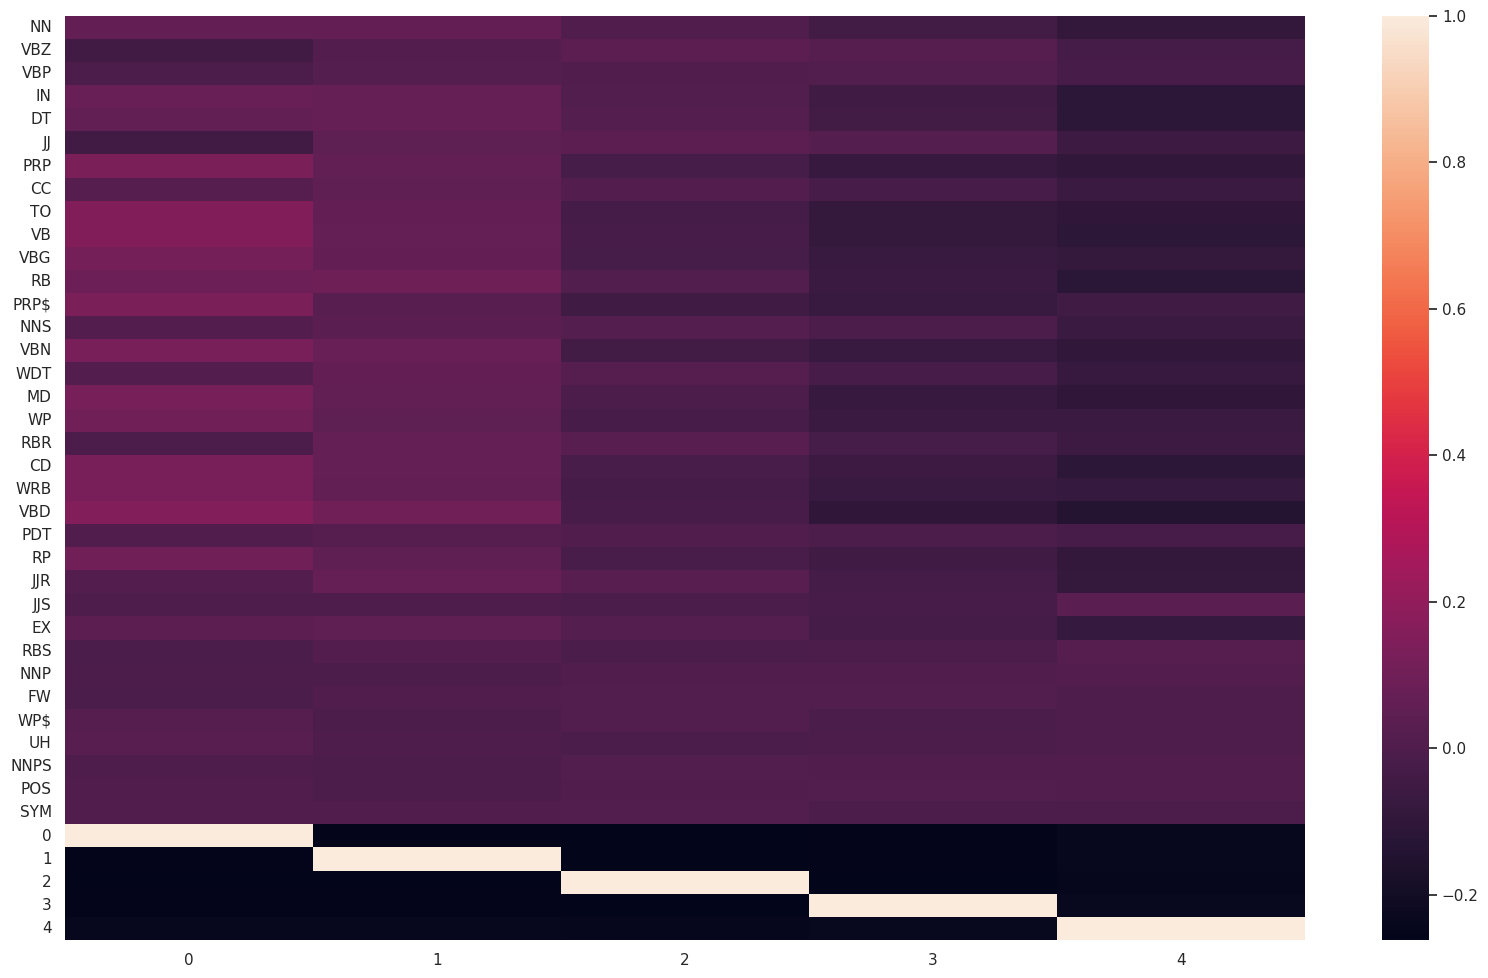

In [ ]:
sns.set(font_scale=1)
plt.figure(figsize=(20,12))
sns.heatmap(pt_df.corr()[['0','1','2','3','4']])
plt.show()

**One can say that as rate increases, number of pos tags also increases. Eventhough it is true, there is still lower correlation between them (Look the values below). So we avoid to use POS Tagging.**

In [ ]:
import pandas as pd

# Example DataFrame
df = corr_matrix

# Find the max value in each row
max_values_per_row = df.max(axis=1)
print("Max values in each row:")
print(max_values_per_row)



Max values in each row:
NN      0.061131
VBZ     0.042756
VBP     0.019128
IN      0.076849
DT      0.071544
JJ      0.045126
PRP     0.135931
CC      0.051673
TO      0.151342
VB      0.148402
VBG     0.116000
RB      0.088405
PRP$    0.132841
NNS     0.038213
VBN     0.127063
WDT     0.061398
MD      0.119335
WP      0.103850
RBR     0.065661
CD      0.124815
WRB     0.125682
VBD     0.155428
PDT     0.024043
RP      0.102524
JJR     0.072413
JJS     0.036803
EX      0.049923
RBS     0.019526
NNP     0.009586
FW      0.007983
WP$     0.021969
UH      0.025651
NNPS    0.007292
POS     0.004511
SYM     0.008270
0       1.000000
1       1.000000
2       1.000000
3       1.000000
4       1.000000
dtype: float64


So finally we are sure about the text representation of our data. But what about the embeddings? The CountVectorizer is very fast and interpretable, however it is very trivial. We have used TF-IDF Vectorizer to represent better text data.


TF-IDF (Term Frequency-Inverse Document Frequency) Vectorizer is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents (corpus). It is commonly used in information retrieval and text mining to transform text data into numerical representations, making it suitable for machine learning algorithms. 

In [ ]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(x, y, test_size = 0.2, random_state = 2022)

We also find bigrams in our vectorizer.
A bigram is a sequence of two adjacent elements from a string of tokens, which are typically words in the context of natural language processing (NLP). Bigrams are a type of n-gram, where n represents the number of elements in the sequence. While unigrams are single words, bigrams consist of pairs of consecutive words.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range = (1, 2), min_df=10)
vectorizer.fit(x_train)
X_train = vectorizer.transform(x_train)
X_test = vectorizer.transform(x_val)
X_train.toarray()
X_test.toarray()
Y_train = np.array(y_train)
Y_test = np.array(y_val)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc,f1_score


# Create a multinomial logistic regression classifier
classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=1000)

# Train the classifier
classifier.fit(X_train, Y_train)


LogisticRegression(max_iter=1000, multi_class='multinomial')

Accuracy: 0.5991538461538461
F1-Score: 0.5916673462878368
Confusion Matrix:
 [[2365  519   70   19   32]
 [ 632 1355  478   85   47]
 [ 146  495 1243  493  112]
 [  69  109  492 1255  592]
 [  77   45   99  600 1571]]


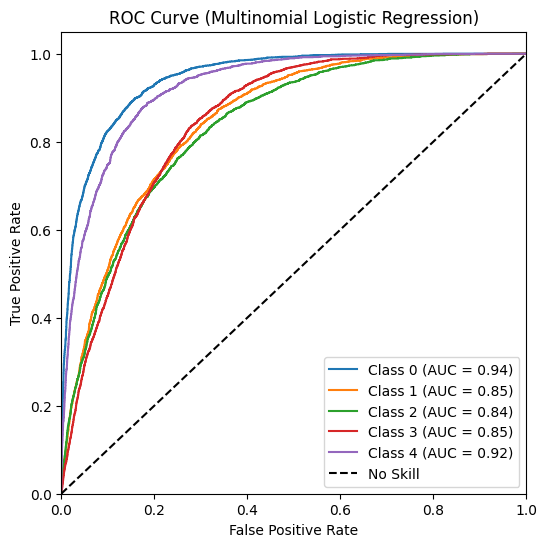

In [ ]:
# Predict class labels for test data
y_pred_test = classifier.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(Y_test, y_pred_test)
print("Accuracy:", accuracy)
f1_score = f1_score(Y_test, y_pred_test, average='macro')
print("F1-Score:", f1_score)

# Calculate Confusion Matrix
confusion_matrix_result = confusion_matrix(Y_test, y_pred_test)
print("Confusion Matrix:\n", confusion_matrix_result)

# ROC Curve and AUC Score
# One-vs-Rest approach for ROC curve (as Multinomial Logistic Regression doesn't directly output probabilities)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(classifier.classes_)

for i in range(n_classes):
    y_test_binary = (Y_test == i)  # Binarize for each class
    fpr[i], tpr[i], _ = roc_curve(y_test_binary, classifier.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class %d (AUC = %0.2f)' % (i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multinomial Logistic Regression)')
plt.legend(loc="lower right")
plt.show()

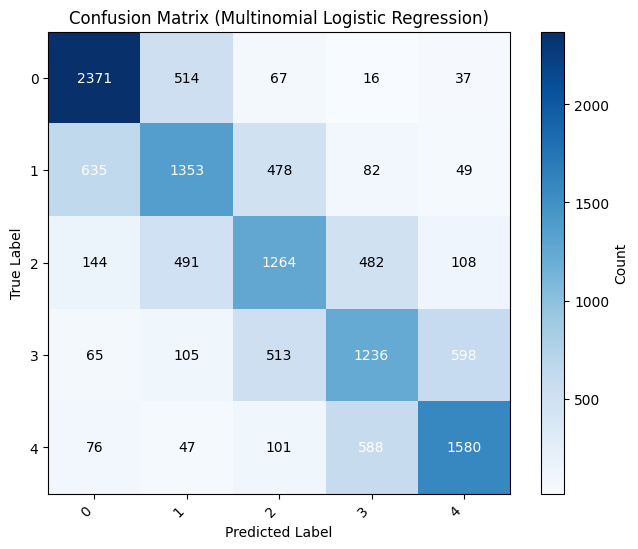

In [ ]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix_result, cmap='Blues')
plt.colorbar(label='Count')

# Set labels for axes
class_names = [str(x) for x in range(len(classifier.classes_))]  # Adapt based on your class names
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.yticks(range(len(class_names)), class_names)

# Add text for each cell (optional)
for i in range(len(confusion_matrix_result)):
    for j in range(len(confusion_matrix_result[0])):
        plt.text(j, i, confusion_matrix_result[i, j], ha='center', va='center', color='white' if confusion_matrix_result[i, j] > np.mean(confusion_matrix_result) else 'black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Multinomial Logistic Regression)')
plt.show()

**For Test set**

In [ ]:
X_test_test = test_df['text']
Y_test_test = test_df['label']
X_test_test_preprocessed = []
for text in X_test_test:
    X_test_test_preprocessed.append(preprocess(text))
X_test_test = X_test_test_preprocessed
x_test = vectorizer.transform(X_test_test)
x_test.toarray()
y_test = np.array(Y_test_test)

Accuracy: 0.58456
F1-Score: 0.5842360995582105
Confusion Matrix:
 [[7532 2040  213   96  119]
 [2329 5312 1879  343  137]
 [ 541 2261 4980 1848  370]
 [ 208  437 2205 5103 2047]
 [ 276  149  444 2830 6301]]


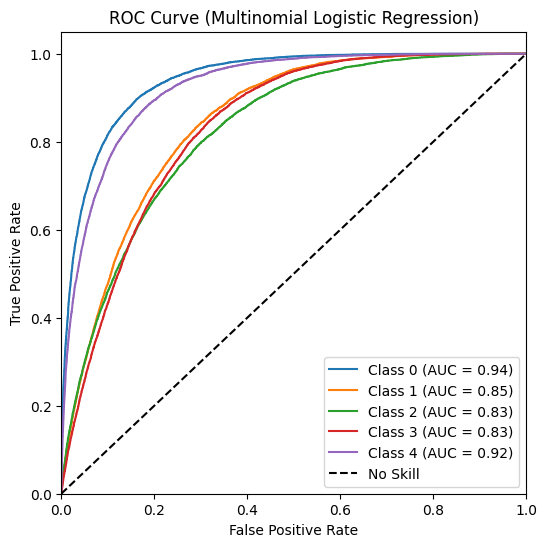

In [ ]:
# Predict class labels for test data
y_pred_test = classifier.predict(x_test)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy:", accuracy)
f1_score = metrics.f1_score(y_test, y_pred_test, average='macro')
print("F1-Score:", f1_score)

# Calculate Confusion Matrix
confusion_matrix_result = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:\n", confusion_matrix_result)

# ROC Curve and AUC Score
# One-vs-Rest approach for ROC curve (as Multinomial Logistic Regression doesn't directly output probabilities)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(classifier.classes_)

for i in range(n_classes):
    y_test_binary = (y_test == i)  # Binarize for each class
    fpr[i], tpr[i], _ = roc_curve(y_test_binary, classifier.predict_proba(x_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class %d (AUC = %0.2f)' % (i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multinomial Logistic Regression)')
plt.legend(loc="lower right")
plt.show()

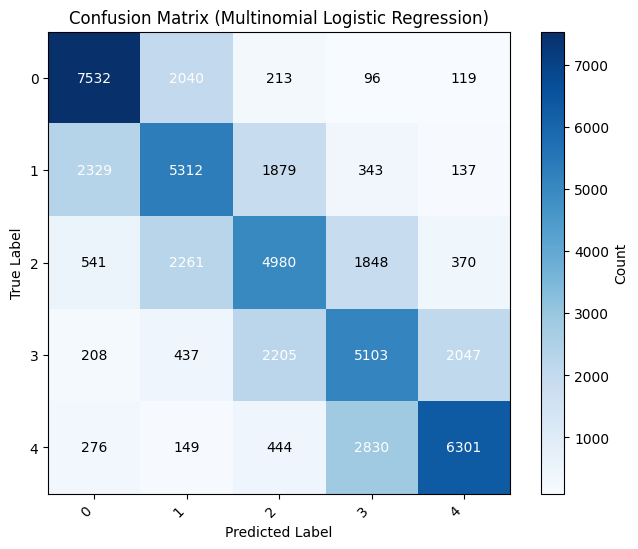

In [ ]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix_result, cmap='Blues')
plt.colorbar(label='Count')

# Set labels for axes
class_names = [str(x) for x in range(len(classifier.classes_))]  # Adapt based on your class names
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.yticks(range(len(class_names)), class_names)

# Add text for each cell (optional)
for i in range(len(confusion_matrix_result)):
    for j in range(len(confusion_matrix_result[0])):
        plt.text(j, i, confusion_matrix_result[i, j], ha='center', va='center', color='white' if confusion_matrix_result[i, j] > np.mean(confusion_matrix_result) else 'black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Multinomial Logistic Regression)')
plt.show()

Logistic Regression with TF-IDF Vectorizer gives better result than Count Vectorizer. Especially for reviews with 0 label, it gives way better accuracy.

#### WORD2VEC Embedding

Without implementing further models, we have focused on Word2Vec and using it as embedding to our training model.

Word2Vec is a popular technique in natural language processing (NLP) that transforms words into numerical vectors in a continuous vector space. Developed by a team of researchers led by Tomas Mikolov at Google in 2013, Word2Vec captures semantic and syntactic relationships between words based on their context in a large corpus of text. The resulting word embeddings (vector representations) can then be used in various NLP tasks.

##### Training Process

- Corpus Preparation: A large corpus of text is collected and preprocessed. This involves tokenization, removal of stop words, and possibly stemming or lemmatization.

- Context Window: A sliding window is used to define the context of each word. For example, with a window size of 2, the context of a word includes the two words before and after it.

- Model Training: The neural network is trained to maximize the probability of context words given a target word (Skip-gram) or a target word given context words (CBOW). The training adjusts the weights of the neural network, which correspond to the word vectors.

Advantages:
* Semantic Similarity: Words with similar meanings tend to have similar vectors, enabling semantic understanding.
* Efficient Computation: The models are relatively simple and can be trained efficiently on large datasets.
* Transfer Learning: Pre-trained Word2Vec models can be fine-tuned for specific NLP tasks, reducing the need for extensive retraining.

We have creted different word2vec models changing configurations such as window size, vector size etc. All the models are available on the Github Repository.

In [ ]:
from gensim.models import Word2Vec

data = []
for sentence in x:
    data.append(sentence.split())

# Define Word2Vec parameters
vector_size = 256  # Dimensionality of the word vectors, we use 100, 256 and 512
window = 5  # Maximum distance between the current and predicted word within a sentence
min_count = 10  # Ignores all words with a total frequency lower than this, we use 1 and 10
sg = 1  # Training algorithm: CBOW (0) or skip-gram (1)

# Train Word2Vec model
model = Word2Vec(sentences=data, vector_size=vector_size, window=window, min_count=min_count, sg=sg)

# Optionally train for more epochs
# model.train(data, total_examples=model.corpus_count, epochs=10)
# Save the trained model to a file
model.save('word2vec_model.bin')


The codes above contains examples from with configuration:
vector_size = 256
window=5
min_count=10
sg=1
The examples from other models is stated.

##### Similar Words, Analogies and Other Experiments

Let's find similar words.

In [ ]:
# Find similar words
similar_words_amazing = model.wv.most_similar('amazing')
similar_words_terrible = model.wv.most_similar('terrible')

In [ ]:
similar_words_amazing

[('incredible', 0.8868997693061829),
 ('awesome', 0.884756863117218),
 ('fantastic', 0.852196455001831),
 ('phenomenal', 0.8384959697723389),
 ('fabulous', 0.786296546459198),
 ('outstanding', 0.7801915407180786),
 ('wonderful', 0.7527675628662109),
 ('excellent', 0.7492627501487732),
 ('superb', 0.7274727821350098),
 ('terrific', 0.7265809178352356)]

In [ ]:
similar_words_terrible

[('horrible', 0.9425191879272461),
 ('awful', 0.8715782165527344),
 ('horrendous', 0.8070825338363647),
 ('horrid', 0.8062782883644104),
 ('lousy', 0.7586703896522522),
 ('atrocious', 0.7233906388282776),
 ('horrific', 0.6967999935150146),
 ('aweful', 0.6909676790237427),
 ('dreadful', 0.6837438941001892),
 ('bad', 0.6736840605735779)]

In [ ]:
# Find similar words
similar_words = model.wv.most_similar('sushi', topn=5)
print('Similar words to "sushi":', similar_words)

# Calculate cosine similarity between two words
similarity_score = model.wv.similarity('italian', 'sushi')
print('Cosine similarity between "italian" and "sushi":', similarity_score)

# Calculate cosine similarity between two words
similarity_score = model.wv.similarity('italian', 'pizza')
print('Cosine similarity between "italian" and "pizza":', similarity_score)

# Calculate cosine similarity between two words
similarity_score = model.wv.similarity('japanese', 'sushi')
print('Cosine similarity between "japanese" and "sushi":', similarity_score)

# Calculate cosine similarity between two words
similarity_score = model.wv.similarity('japanese', 'pizza')
print('Cosine similarity between "japanese" and "pizza":', similarity_score)


Similar words to "sushi": [('sashimi', 0.7559454441070557), ('nigiri', 0.7263278365135193), ('ayce', 0.713910698890686), ('maki', 0.6613011956214905), ('sushis', 0.6272545456886292)]
Cosine similarity between "italian" and "sushi": 0.26738885
Cosine similarity between "italian" and "pizza": 0.4306146
Cosine similarity between "japanese" and "sushi": 0.52857655
Cosine similarity between "japanese" and "pizza": 0.118901804


As we expected, "italian" and "pizza" are very similar. "Japanese" and "sushi" are have more similarity. For sushi-italian and pizza-italian, scores are lower.

Analogy tasks with Word2Vec involve finding relationships between words based on their vector representations. The idea is that the relationships captured by the vectors in the embedding space can be used to solve analogy problems, such as "man is to king as woman is to queen." Word2Vec models learn these relationships during training, and the resulting embeddings can be used to perform such tasks effectively.

In [ ]:

analogy1 = model.wv.most_similar(positive=['wine', 'malt'], negative=['grape'], topn=3)
print('1. Analogy: wine - grape + malt =', analogy1[0])

analogy1 = model.wv.most_similar(positive=['pesto', 'tomato'], negative=['basil'], topn=3)
print('1. Analogy: pesto - basil + tomato =', analogy1[0])



1. Analogy: wine - grape + malt = ('beer', 0.5273988842964172)
1. Analogy: pesto - basil + tomato = ('sundried', 0.6006603240966797)


<img src="https://www.thespruceeats.com/thmb/N9TEoqtQz-R9zkjMXM8I530sj30=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/red-wine-is-poured-into-a-glass-from-a-bottle--light-background--1153158143-98320451802c485cb6d7b5437c7fd60a.jpg" alt="drawing" width="100"/> <img src="https://static.vecteezy.com/system/resources/previews/000/380/520/original/minus-vector-icon.jpg" alt="drawing" width="100"/> <img src="https://img.imageboss.me/fourwinds/width/425/dpr:2/shop/products/blackmonukka.jpg?v=1538780984" alt="drawing" width="100"/> <img src="https://t4.ftcdn.net/jpg/01/26/10/59/360_F_126105961_6vHCTRX2cPOnQTBvx9OSAwRUapYTEmYA.jpg" alt="drawing" width="100"/> <img src="https://upload.wikimedia.org/wikipedia/commons/9/98/Gr%C3%BCnmalz.jpg" alt="drawing" width="100"/> <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSMEfkQITJ-uqEIX76ghbK8OeHLF5Bvbks2L8RzmKJY3g&s" alt="drawing" width="100"/> <img src="https://static.toiimg.com/thumb/93353895.cms?width=400&height=300&resizemode=4&imgsize=54288" alt="drawing" width="100"/> 

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c9/BasilPesto.JPG" alt="drawing" width="100"/> <img src="https://static.vecteezy.com/system/resources/previews/000/380/520/original/minus-vector-icon.jpg" alt="drawing" width="100"/> <img src="https://www.clickandgrow.com/cdn/shop/products/Basil_plant_1280x960_0fc95446-605c-49e3-aa42-c6f3a171b8ae.jpg" alt="drawing" width="100"/> <img src="https://t4.ftcdn.net/jpg/01/26/10/59/360_F_126105961_6vHCTRX2cPOnQTBvx9OSAwRUapYTEmYA.jpg" alt="drawing" width="100"/> <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/89/Tomato_je.jpg/1200px-Tomato_je.jpg" alt="drawing" width="100"/> <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSMEfkQITJ-uqEIX76ghbK8OeHLF5Bvbks2L8RzmKJY3g&s" alt="drawing" width="100"/> <img src="https://www.budgetbytes.com/wp-content/uploads/2012/08/Not-Sun-Dried-Tomato-Sauce-front.jpg" alt="drawing" width="100"/> 

With the Word2Vec model with 512 vector size, second one becomes "marinara":

In [ ]:

analogy1 = model.wv.most_similar(positive=['wine', 'malt'], negative=['grape'], topn=3)
print('1. Analogy: wine - grape + malt =', analogy1[0])

analogy1 = model.wv.most_similar(positive=['pesto', 'tomato'], negative=['basil'], topn=3)
print('1. Analogy: pesto - basil + tomato =', analogy1[0])



1. Analogy: wine - grape + malt = ('beer', 0.6625512838363647)
1. Analogy: pesto - basil + tomato = ('marinara', 0.7865259647369385)


<img src="https://upload.wikimedia.org/wikipedia/commons/c/c9/BasilPesto.JPG" alt="drawing" width="100"/> <img src="https://static.vecteezy.com/system/resources/previews/000/380/520/original/minus-vector-icon.jpg" alt="drawing" width="100"/> <img src="https://www.clickandgrow.com/cdn/shop/products/Basil_plant_1280x960_0fc95446-605c-49e3-aa42-c6f3a171b8ae.jpg" alt="drawing" width="100"/> <img src="https://t4.ftcdn.net/jpg/01/26/10/59/360_F_126105961_6vHCTRX2cPOnQTBvx9OSAwRUapYTEmYA.jpg" alt="drawing" width="100"/> <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/89/Tomato_je.jpg/1200px-Tomato_je.jpg" alt="drawing" width="100"/> <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSMEfkQITJ-uqEIX76ghbK8OeHLF5Bvbks2L8RzmKJY3g&s" alt="drawing" width="100"/> <img src="https://i2.wp.com/www.downshiftology.com/wp-content/uploads/2019/06/Marinara-Sauce-main.jpg" alt="drawing" width="100"/> 

In [ ]:
# Find similar words
similar_words = model.wv.most_similar('sushi', topn=5)
print('Similar words to "sushi":', similar_words)

Similar words to "sushi": [('sashimi', 0.7559454441070557), ('nigiri', 0.7263278365135193), ('ayce', 0.713910698890686), ('maki', 0.6613011956214905), ('sushis', 0.6272545456886292)]


In [ ]:
# Find similar words
similar_words = model.wv.most_similar('italian', topn=5)
print('Similar words to "italian":', similar_words)

Similar words to "italian": [('mexican', 0.6268699169158936), ('mediterranean', 0.6218019127845764), ('stallion', 0.6103924512863159), ('greek', 0.6076419353485107), ('asian', 0.5981730222702026)]


In [ ]:
# Word frequencies
word_freq = model.wv.key_to_index
most_common_words = sorted(word_freq, key=word_freq.get, reverse=False)[:10]
print('Most common words:', most_common_words)

Most common words: ['the', 'and', 'i', 'a', 'to', 'was', 'it', 'is', 'of', 'not']


Then we viusalized the vector space with T-SNE. Contrary to methods we did in data exploration part such as k-means, T-SNE result seems more meaningful in the 3-D Space. This encourage us to use these embeddings in Logistic Regression and SVM.

In [ ]:
def get_average_word2vec(sentence):
    word_vectors = []
    for word in sentence.split():
        if word in model.wv:
            word_vectors.append(model.wv[word])
    if len(word_vectors)>0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Assuming you have a list of sentences and their corresponding labels
sentences = x  # List of sentences
labels = y  # List of corresponding labels

# Convert labels to numeric values
label_to_numeric = {label: i for i, label in enumerate(set(labels))}
numeric_labels = np.array([label_to_numeric[label] for label in labels])

In [ ]:
# Convert sentences to their corresponding Word2Vec embeddings
sentence_vectors = []
for sentence in sentences[:10000]:
    # Assuming you have a function to convert each sentence to its Word2Vec embedding
    vector = get_average_word2vec(sentence)  # Example function to get Word2Vec embedding
    sentence_vectors.append(vector)

sentence_vectors = np.array(sentence_vectors)

# Perform t-SNE
tsne = TSNE(n_components=3, random_state=42)
vectors_3d = tsne.fit_transform(sentence_vectors)



<Figure size 1000x800 with 0 Axes>

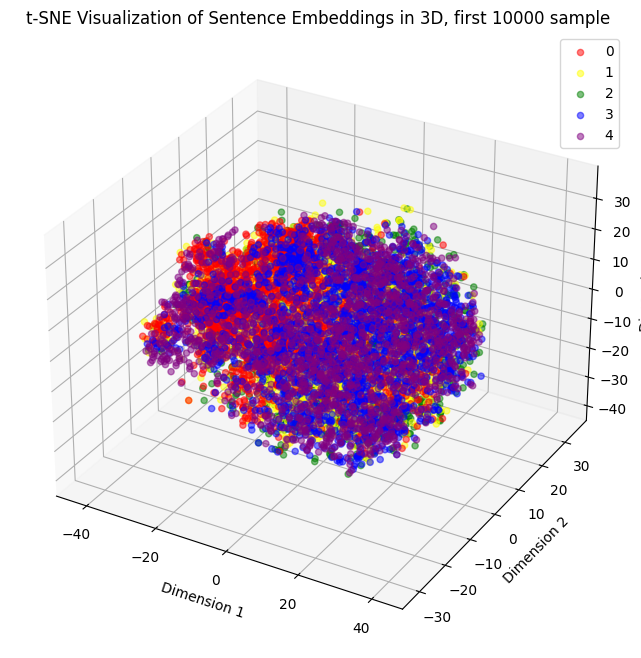

In [ ]:
# Plot
label_colors = {"0":"red","1":"yellow","2":"green","3":"blue","4":"purple"}
plt.figure(figsize=(10, 8))
# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
numeric_labels = numeric_labels[:10000]
for label, color in label_colors.items():
    indices = numeric_labels == label_to_numeric[int(label)]
    ax.scatter(vectors_3d[indices, 0], vectors_3d[indices, 1], vectors_3d[indices, 2], c=color, label=label, alpha=0.5)

ax.set_title('t-SNE Visualization of Sentence Embeddings in 3D, first 10000 sample')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend()
plt.show()

Below visual is from the model with vector size 512:

<Figure size 1000x800 with 0 Axes>

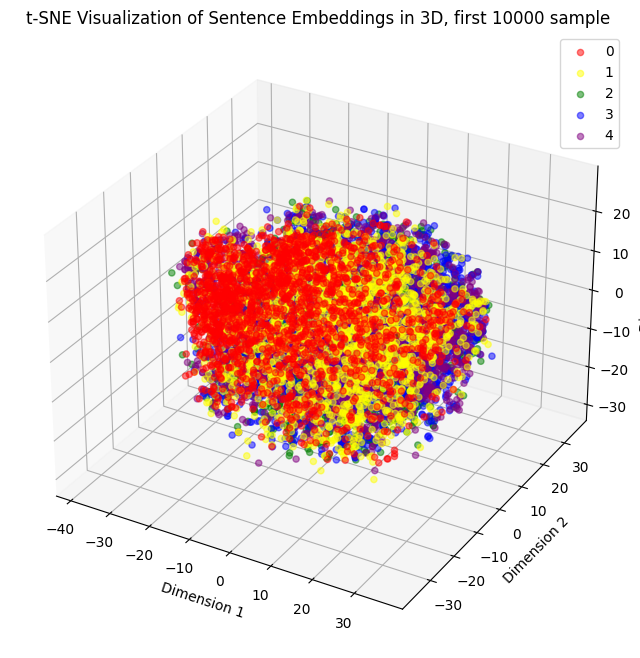

In [ ]:
# Plot
label_colors = {"0":"red","1":"yellow","2":"green","3":"blue","4":"purple"}
plt.figure(figsize=(10, 8))
# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
numeric_labels = numeric_labels[:10000]
for label, color in label_colors.items():
    indices = numeric_labels == label_to_numeric[int(label)]
    ax.scatter(vectors_3d[indices, 0], vectors_3d[indices, 1], vectors_3d[indices, 2], c=color, label=label, alpha=0.5)

ax.set_title('t-SNE Visualization of Sentence Embeddings in 3D, first 10000 sample')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend()
plt.show()

In [ ]:
# Find similar words
similar_words = model.wv.similar_by_word('patronizing', topn=5)
print('Similar words to "patronizing":', similar_words)

Similar words to "patronizing": [('frequenting', 0.5402674674987793), ('patronize', 0.5291619300842285), ('unproffesional', 0.5280306935310364), ('behaviour', 0.5170702934265137), ('unkind', 0.511965274810791)]


In [ ]:
query = "The stuff is rude.Their attitude is so bad"
query_vector = get_average_word2vec(query)
similar_sentences = []
for sentence in x[:65000]:
    sentence_vector = get_average_word2vec(sentence)
    similarity_score = np.dot(query_vector, sentence_vector) / (np.linalg.norm(query_vector) * np.linalg.norm(sentence_vector))
    similar_sentences.append((sentence, similarity_score))
similar_sentences = sorted(similar_sentences, key=lambda x: x[1], reverse=True)[:5]
print("Top similar sentences:")
for sentence, score in similar_sentences:
    print(f"- {sentence} (Similarity: {score})")

/tmp/ipykernel_33/3910004658.py:6: RuntimeWarning: invalid value encountered in scalar divide
  similarity_score = np.dot(query_vector, sentence_vector) / (np.linalg.norm(query_vector) * np.linalg.norm(sentence_vector))


Top similar sentences:
- awful  food is bad and there is nogood service  (Similarity: 0.8291990756988525)
- bad attitudes from the workers  the food is not that great to put up with the mood of this place  this is not like the soup nazi from seinfeld  sometimes the place is open and sometimes it is not which makes for crappy business  (Similarity: 0.8150925040245056)
- this place is dirty  the owner is miserable and the food is terrible  it is amazing they have been in business this long  (Similarity: 0.8122240304946899)
- food is good but beware of racial bias  bad attitudes  if your skin color is darker than the mongloids running the place expect bad attitudes  the midget that works the drive thru window was the worse  but she is better now  still will not give me eye contact  the younger ore american girl that works there has always been nice    but funny  (Similarity: 0.8067569732666016)
- it is very inconsistent here in terms of barista skills  unfortunately  sometimes i get a gre

In [ ]:
query = "Italian restaurant with great ambiance"
query_vector = get_average_word2vec(query)
similar_sentences = []
for sentence in x[:65000]:
    sentence_vector = get_average_word2vec(sentence)
    similarity_score = np.dot(query_vector, sentence_vector) / (np.linalg.norm(query_vector) * np.linalg.norm(sentence_vector))
    similar_sentences.append((sentence, similarity_score))
similar_sentences = sorted(similar_sentences, key=lambda x: x[1], reverse=True)[:5]
print("Top similar sentences:")
for sentence, score in similar_sentences:
    print(f"- {sentence} (Similarity: {score})")


/tmp/ipykernel_33/1729701784.py:6: RuntimeWarning: invalid value encountered in scalar divide
  similarity_score = np.dot(query_vector, sentence_vector) / (np.linalg.norm(query_vector) * np.linalg.norm(sentence_vector))


Top similar sentences:
- great ambience and food  (Similarity: 0.8416973352432251)
- the food was excellent  the ambiance cozy   great for date night  (Similarity: 0.8380798101425171)
- great restaurant with great food nice wine  the inside ambience is good but there is no nice view of the city  (Similarity: 0.8358926177024841)
- great thai food   ambiance is great  good service  great food  (Similarity: 0.8319563269615173)
- great service  food was good bar food nice atmosphere  great place to chill and have a beer  (Similarity: 0.8269951939582825)


We developed a Logictic Regression Model with the help of Word2Vec embedding.

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 2022)

In [ ]:
# Assuming you have a list of sentences and their corresponding labels
sentences = x_train  # List of sentences
labels = y_train  # List of corresponding labels

# Convert labels to numeric values
label_to_numeric = {label: i for i, label in enumerate(set(labels))}
numeric_labels = np.array([label_to_numeric[label] for label in labels])

In [ ]:
# Convert sentences to their corresponding Word2Vec embeddings
sentence_vectors = []
for sentence in sentences:
    # Assuming you have a function to convert each sentence to its Word2Vec embedding
    vector = get_average_word2vec(sentence)  # Example function to get Word2Vec embedding
    sentence_vectors.append(vector)

sentence_vectors = np.array(sentence_vectors)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc


# Create a multinomial logistic regression classifier
classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=1000)

# Train the classifier
classifier.fit(sentence_vectors, labels)

# Predict class labels for test data
y_pred_test = classifier.predict(val_sentence_vectors)

# Calculate Accuracy
accuracy = accuracy_score(y_val, y_pred_test)
print("Accuracy:", accuracy)

# Calculate Confusion Matrix
confusion_matrix_result = confusion_matrix(y_val, y_pred_test)
print("Confusion Matrix:\n", confusion_matrix_result)

Accuracy: 0.5862538461538461
Confusion Matrix:
 [[19511  5318   667   196   365]
 [ 5753 13659  5207   758   438]
 [ 1209  5688 12915  4963  1167]
 [  411  1082  5872 12749  6125]
 [  531   426  1201  6410 17379]]


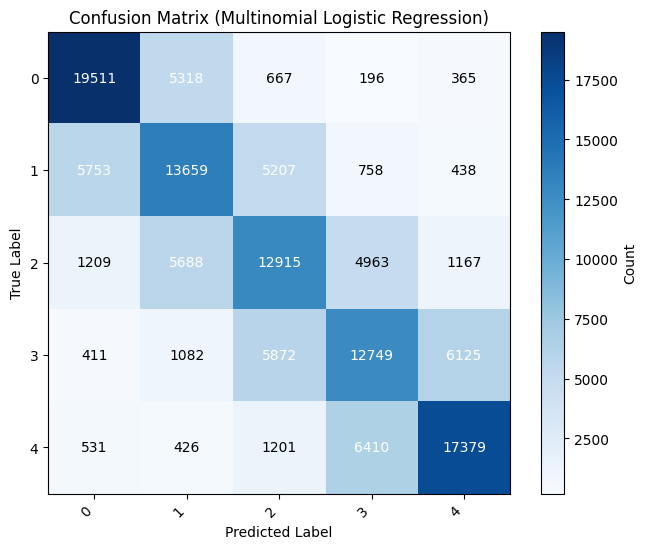

In [ ]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix_result, cmap='Blues')
plt.colorbar(label='Count')

# Set labels for axes
class_names = [str(x) for x in range(len(classifier.classes_))]  # Adapt based on your class names
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.yticks(range(len(class_names)), class_names)

# Add text for each cell (optional)
for i in range(len(confusion_matrix_result)):
    for j in range(len(confusion_matrix_result[0])):
        plt.text(j, i, confusion_matrix_result[i, j], ha='center', va='center', color='white' if confusion_matrix_result[i, j] > np.mean(confusion_matrix_result) else 'black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Multinomial Logistic Regression)')
plt.show()

Lastly, we use Word2Vec with TF-IDF Vectorizer. TF_IDF Weighted Word2Vec Logistic Regression give worse result than what we expected. As a future work, one may can work on this method. We hace reached %54 accuracy with this kind of model. (You can find the notebook on repository. Below you can find vector calculation code).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=10)
tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)

# Get the vocabulary and the tf-idf scores
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray()
feature_names_dict = {}
for i, name in enumerate(tfidf_feature_names.tolist()):
    feature_names_dict[name] = i

# Function to create TF-IDF weighted Word2Vec embedding for a document
def create_embedding(document, model, tfidf_vectorizer, tfidf_scores, feature_names_dict, i):
    words = document.split()
    doc_embedding = np.zeros(model.vector_size)
    weighted_sum = 0
    
    for word in words:
        if word in model.wv:
            tfidf_index = feature_names_dict[word] if word in feature_names_dict else -1
            if tfidf_index != -1:
                tfidf_score = tfidf_scores[tfidf_index]
                word_embedding = model.wv[word]
                doc_embedding += word_embedding * tfidf_score
                weighted_sum += tfidf_score

    if weighted_sum != 0:
        doc_embedding /= weighted_sum

    return doc_embedding
    

#### SVM

Support Vector Machine (SVM) is a powerful supervised learning algorithm used for classification and regression tasks in machine learning. It is particularly well-suited for binary classification problems but can be extended to handle multi-class classification as well.

Key Concepts of SVM
* Hyperplane: In SVM, a hyperplane is a decision boundary that separates data points of different classes. In two dimensions, this is a line; in three dimensions, it is a plane; and in higher dimensions, it is called a hyperplane.

* Support Vectors: Support vectors are the data points that are closest to the hyperplane and thus are the most difficult to classify. These points are critical as they define the position and orientation of the hyperplane.

* Margin: The margin is the distance between the hyperplane and the nearest support vectors of any class. SVM aims to maximize this margin, leading to a decision boundary that is as far away from the closest data points of any class as possible. This is known as the maximum margin classifier.



We have used the embeddings above with SVM.

Radial Basis Function(RBF) kernel is needed when the data is really unevenly distributed. So we use poly kernel.

In [ ]:
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


In [ ]:
poly = svm.SVC(kernel='poly', degree=3, C=1,verbose=True).fit(sentence_vectors[:65000], labels[:65000])

[LibSVM]...........*..*.*
optimization finished, #iter = 13823
obj = -14637.241142, rho = -0.844666
nSV = 15609, nBSV = 15181
.......*..*.*
optimization finished, #iter = 9405
obj = -7744.039311, rho = -0.269098
nSV = 8889, nBSV = 8493
....
*..*
optimization finished, #iter = 6006
obj = -4465.473865, rho = -0.633883
nSV = 5579, nBSV = 5228
....*.*.*
optimization finished, #iter = 5763
obj = -3806.624718, rho = -0.075940
nSV = 4848, nBSV = 4522
............*.
*.*
optimization finished, #iter = 14435
obj = -16088.882707, rho = 1.027395
nSV = 17192, nBSV = 16766
........*.*
optimization finished, #iter = 9482
obj = -8536.812691, rho = 0.719639
nSV = 9873, nBSV = 9500
.....*.*
optimization finished, #iter = 6405
obj = -5492.025257, rho = 0.934755
nSV = 6671, nBSV = 6338
............*.*
optimization finished, #iter = 13820
obj = -16299.600256, rho = 0.282674
nSV = 17448, nBSV = 16969
........*..*.*
optimization finished, #iter = 10879
obj = -9115.197410, rho = 0.720638
nSV = 10322, nBSV = 9

In [ ]:
y_pred_test = poly.predict(val_sentence_vectors[:10000])

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

In [ ]:
# Calculate Accuracy
accuracy = accuracy_score(y_val[:10000], y_pred_test)
print("Accuracy:", accuracy)

# Calculate Confusion Matrix
confusion_matrix_result = confusion_matrix(y_val[:10000], y_pred_test)
print("Confusion Matrix:\n", confusion_matrix_result)

f1_score = f1_score(y_val[:10000], y_pred_test, average='weighted')
print('F1 (Polynomial Kernel): ', "%.2f" % (f1_score*100))

Accuracy: 0.5783
Confusion Matrix:
 [[1468  440   64   14   27]
 [ 460 1010  421   59   32]
 [  95  446  950  402   61]
 [  31   83  451 1098  417]
 [  31   52   97  534 1257]]
F1 (Polynomial Kernel):  57.90


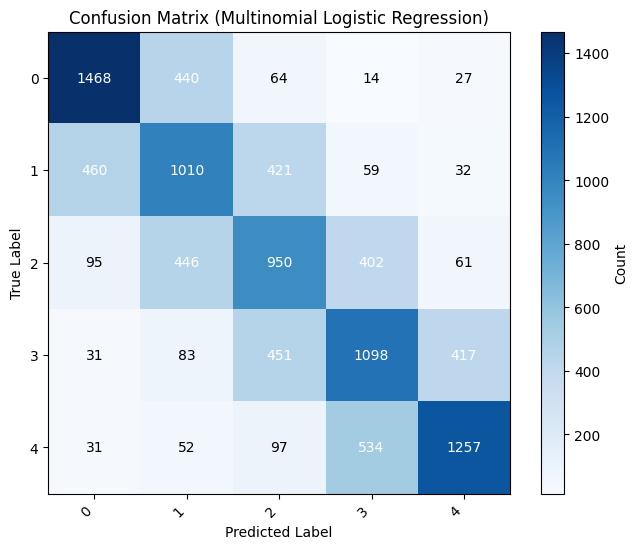

In [ ]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix_result, cmap='Blues')
plt.colorbar(label='Count')

# Set labels for axes
class_names = [str(x) for x in range(5)]  # Adapt based on your class names
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.yticks(range(len(class_names)), class_names)

# Add text for each cell (optional)
for i in range(len(confusion_matrix_result)):
    for j in range(len(confusion_matrix_result[0])):
        plt.text(j, i, confusion_matrix_result[i, j], ha='center', va='center', color='white' if confusion_matrix_result[i, j] > np.mean(confusion_matrix_result) else 'black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Multinomial Logistic Regression)')
plt.show()

It gives similar result to Logistic Regression. This makes us to think about our representation of data because at least we hope to reach %60 accuracy. So later in the notebook we have focused on the Deep Learning methods to achive better precision and F1-score.